In [38]:
!pip install torchsummary

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm
from torchsummary import summary

In [39]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])



In [40]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


Files already downloaded and verified


In [41]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [42]:
# classes = trainset.classes
# print(classes)

# class_count = {}
# for _, index in trainset:
#     label = classes[index]
#     if label not in class_count:
#         class_count[label] = 0
#     class_count[label] += 1
# class_count

In [43]:
batch_size = 400

In [44]:
train_loader = DataLoader(trainset, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_loader = DataLoader(testset, batch_size*2, num_workers=3, pin_memory=True)

In [45]:
for b in test_loader:
    x, y = b
    print(x.shape)

torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([400, 3, 32, 32])


In [46]:
print(testset.data.shape)

(10000, 32, 32, 3)


In [47]:
def accuracy(outputs, labels):
    val, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [48]:
def epoch_end(epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [49]:
def validation_step(model, batch, device):
    images, labels = batch[0].to(device) , batch[1].to(device)
    out = model(images)                    # Generate predictions
    loss = nn.functional.cross_entropy(out, labels)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

In [50]:
def evaluate(model, val_loader, device):
    outputs = [validation_step(model, batch, device) for batch in val_loader]
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, lr, model, train_loader, test_loader, opt_func=torch.optim.Adam, device = torch.device('cuda'), grad_clip=None):
    history = []

    optimizer = opt_func(model.parameters(), lr, weight_decay = 1e-4)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            images, labels = batch[0].to(device) , batch[1].to(device)
            out = model(images)                  # Generate predictions
            loss = nn.functional.cross_entropy(out, labels) # Calculate loss
            train_losses.append(loss)
            loss.backward()
            
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, test_loader, device)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        epoch_end(epoch, result)
        history.append(result)
    return history

In [51]:
torch.cuda.is_available()

True

In [52]:
device = torch.device('cuda')
device

device(type='cuda')

In [53]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [54]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [55]:
for b in test_loader:
    x, y = b
    print(x.shape)

torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([800, 3, 32, 32])
torch.Size([400, 3, 32, 32])


Training

In [56]:
input_size = 3*32*32
output_size = 10

In [57]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [58]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, x):
        return self.network(x)


In [59]:
# model = CIFAR10Model().to(device, non_blocking=True)

In [60]:
model = ResNet9(3, 10).to(device, non_blocking=True)

In [61]:
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
       BatchNorm2d-5          [-1, 128, 32, 32]             256
              ReLU-6          [-1, 128, 32, 32]               0
         MaxPool2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,584
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [62]:
history = [evaluate(model, test_loader, device)]
history

[{'val_loss': 3.2943193912506104, 'val_acc': 0.10346154123544693}]

In [63]:
# history1 = [evaluate(model, train_loader, device)]
# history1

In [64]:
%%time
epochs = 8
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

his = fit(15, 1e-2, model, train_loader, test_loader, grad_clip=grad_clip)

Epoch [0], last_lr: 0.00151, train_loss: 1.2112, val_loss: 0.8679, val_acc: 0.6967
Epoch [1], last_lr: 0.00435, train_loss: 0.7603, val_loss: 0.7372, val_acc: 0.7422
Epoch [2], last_lr: 0.00759, train_loss: 0.7001, val_loss: 0.7837, val_acc: 0.7422
Epoch [3], last_lr: 0.00971, train_loss: 0.6235, val_loss: 0.6289, val_acc: 0.7855
Epoch [4], last_lr: 0.00994, train_loss: 0.4748, val_loss: 0.5082, val_acc: 0.8326
Epoch [5], last_lr: 0.00950, train_loss: 0.3538, val_loss: 0.5551, val_acc: 0.8220
Epoch [6], last_lr: 0.00867, train_loss: 0.2665, val_loss: 0.5161, val_acc: 0.8363
Epoch [7], last_lr: 0.00750, train_loss: 0.2242, val_loss: 0.4430, val_acc: 0.8602
Epoch [8], last_lr: 0.00611, train_loss: 0.1307, val_loss: 0.4777, val_acc: 0.8483
Epoch [9], last_lr: 0.00463, train_loss: 0.0776, val_loss: 0.4241, val_acc: 0.8733
Epoch [10], last_lr: 0.00317, train_loss: 0.0300, val_loss: 0.4034, val_acc: 0.8829
Epoch [11], last_lr: 0.00188, train_loss: 0.0090, val_loss: 0.3813, val_acc: 0.8964
Ep

In [65]:
history = his


In [66]:
# his, his1 = fit(5, 1e-2, model, train_loader, test_loader)

In [67]:
# history += his
# history1 += his1

In [68]:
# his, his1 = fit(5, 1e-3, model, train_loader, test_loader)

In [69]:
# history += his
# history1 += his1

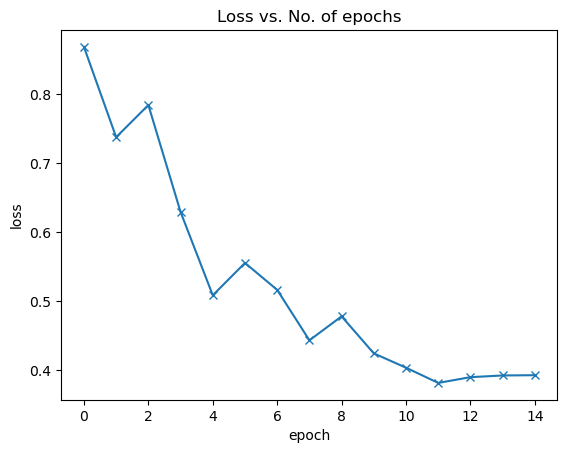

In [70]:
plot_losses(history)

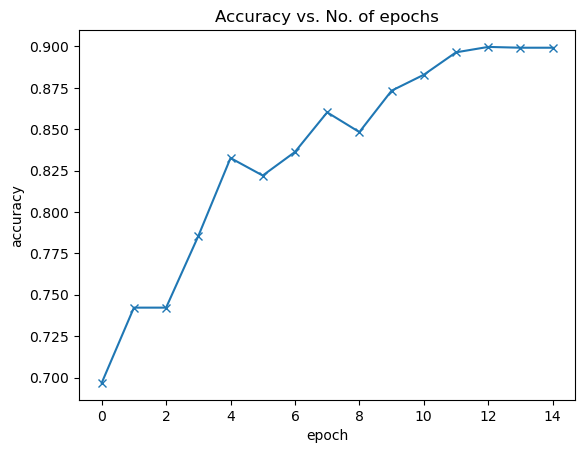

In [71]:
plot_accuracies(history)

In [72]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

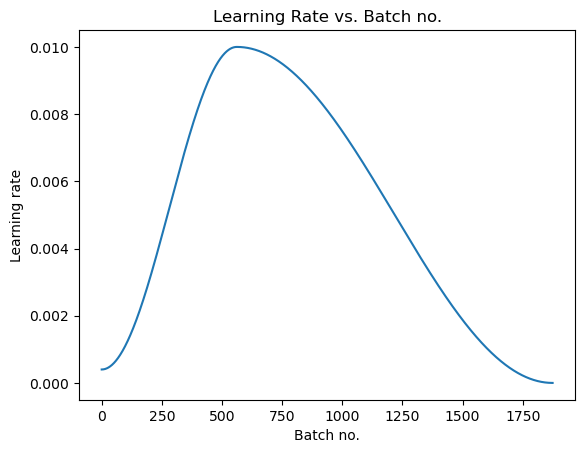

In [73]:
plot_lrs(history)

In [74]:
evaluate(model, test_loader, device)

{'val_loss': 0.3925163745880127, 'val_acc': 0.8992307186126709}